In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, TorsionFingerprints
from rdkit.Chem import Draw, rdMolAlign, PyMol
from rdkit.Chem import SaltRemover
import sys
import os
import matplotlib.pyplot as plt

# Start of Analysis

In [2]:
# is this the first time running the script, do you need to make new files?
# Change True / false if you want to run the long version
create_new_conf_files = False
create_new_csv_files = True

In [3]:
#get all the Final Total Internal Energies for every conformation to recluster the docked poses!
logs_dir = "./docked_dlg/"
df_total = pd.DataFrame()

for logfile_location in os.listdir(logs_dir):
    #print(logfile_location)
    search_string = "DOCKED: USER    (2) Final Total Internal Energy"
    counter = 0
    energy_list = []
    with open(logs_dir+logfile_location, "r") as logfile:
        for index, line in enumerate(logfile):
            if line.startswith(search_string):
                df = pd.DataFrame(line.split(" "))
                df.replace('', np.nan, inplace=True)
                df.dropna(inplace=True)
                df.reset_index(inplace=True, drop=True)
                energy_list.append(float(df.loc[8]))
    #print(len(energy_list))
    df_total[logfile_location[:-13]] = energy_list

In [4]:
# extract all conformations into new file from logfile
#After this function, go run the bash scripts in the folder to go from pdbqt to mol2
dir_docked = "./all_docked_confs/"

end_string = "DOCKED: ENDMDL"


if create_new_conf_files == True:
    
    for filename in df_total:
        print(filename)
        start_string_list = []
        for idx in range(len(df_total[filename])):  
            idx += 1 #index starts with 1 in docking log file
            #different spaces in logfile dependent on digits of molecule index
            if idx < 100:
                start_string = str("DOCKED: MODEL       " + str(idx))
            if idx >= 100:
                start_string = str("DOCKED: MODEL      " + str(idx))
            if idx < 10:
                start_string = str("DOCKED: MODEL        " + str(idx))

            start_string_list.append(start_string)
        print("this many compounds: ", len(start_string_list))


        for start_string in start_string_list:
            mol_counter = 0
            with open(logs_dir+filename+"_dock_log.dlg", "r") as logfile, open(dir_docked+filename+"_all_conformers.pdbqt", "a+") as outfile:
                copy = False
                #print("we are looking for this line:", start_string)

                for line in logfile:
                    if line.startswith(start_string):
                        #print("yay")
                        copy = True
                        continue
                    if copy == True and "DOCKED" in line:
                        copy = True
                    if end_string in line:
                        copy = False
                        mol_counter += 1 # another molecule done.
                        continue
                    if copy:
                        #print(line)
                        outfile.write(line[8:])
                    if mol_counter == 100:
                        break
                outfile.write("\n")

In [5]:
#This code takes all conformations from the mol2 file and loads them into a list as molecules
# don't forget to run the bash scripts in the "all_docked_confs" folder to go from pdbqt to mol2 before running this

def load_multiple_mol2(mol2_file, delimiter="@<TRIPOS>MOLECULE"):
    mol2 = []
    for line in mol2_file:
        if line.startswith(delimiter) and mol2:
            yield "".join(mol2)
            mol2 = []
        mol2.append(line)
    if mol2:
        yield "".join(mol2)

dock_compound_list = []
all_conf_list = []
all_conf_names = []
failed_list = []

df_all_mols = pd.DataFrame()

dock_dir = dir_docked
for input_filename in os.listdir(dock_dir):
    dock_list = []
    check = 0
    if input_filename.endswith(".mol2"):
        print(input_filename)
        with open(dock_dir+input_filename, "r") as f:
            mol2_file = f.readlines()
            dock_compound_list.append(input_filename)
        counter = 1
        for idx, mol2 in enumerate(load_multiple_mol2(mol2_file)):
            #print("mol ", counter) 
            dock_mol = Chem.MolFromMol2Block(mol2)
            if dock_mol == None and input_filename not in failed_list:
                failed_list.append(input_filename)
                check = 1
                print("mol is None: ", idx, input_filename)
                break
            elif dock_mol == None:
                print("check2")
                check = 1
                break
            else:
                #print(dock_mol)
                dock_list.append(dock_mol)
                if counter == 1:
                    all_conf_list.append(dock_mol)
                    all_conf_names.append(str(input_filename))
                counter +=1
        if check == 1:
            print("Faulty")
        elif check == 0:
            assert len(dock_list) == 100
            df_all_mols[input_filename[:-18]] = dock_list

TOB-UNK-c2aba166-1_x1386_all_conforme.mol2
THO-SYG-f9b2970d-8_x1425_all_conforme.mol2
THO-SYG-f9b2970d-7_x1425_all_conforme.mol2
THO-SYG-f9b2970d-6_x1425_all_conforme.mol2
THO-SYG-f9b2970d-5_x1425_all_conforme.mol2
THO-SYG-f9b2970d-4_x1425_all_conforme.mol2
THO-SYG-f9b2970d-3_x1425_all_conforme.mol2
THO-SYG-f9b2970d-2_x1425_all_conforme.mol2
THO-SYG-f9b2970d-1_x1425_all_conforme.mol2
THO-SYG-4e0386bb-3_x1392_all_conforme.mol2
THO-SYG-4e0386bb-2_x1392_all_conforme.mol2
THO-SYG-4e0386bb-1_x1392_all_conforme.mol2
STU-CHA-91df9a40-1_x1382_all_conforme.mol2
STU-CHA-83dacf15-1_x0770_all_conforme.mol2
STU-CHA-814c6126-1_x0770_all_conforme.mol2
STU-CHA-7e77017b-1_x0770_all_conforme.mol2
STU-CHA-7b3b91d5-1_x0770_all_conforme.mol2
STU-CHA-6d5cfe2b-1_x0770_all_conforme.mol2
STU-CHA-6cae54d3-1_x0770_all_conforme.mol2
STU-CHA-545e7bd3-2_x0692_all_conforme.mol2
STU-CHA-5350f95a-1_x0770_all_conforme.mol2
STU-CHA-464c0256-1_x0692_all_conforme.mol2
STU-CHA-0be58c98-1_x0692_all_conforme.mol2
STU-CHA-09b

NIM-UNI-310206f0-16_x0770_all_conforme.mol2
NIM-UNI-310206f0-15_x0770_all_conforme.mol2
NIM-UNI-310206f0-14_x0770_all_conforme.mol2
NIM-UNI-310206f0-13_x0770_all_conforme.mol2
NIM-UNI-310206f0-12_x0770_all_conforme.mol2
NIM-UNI-310206f0-11_x0770_all_conforme.mol2
MIH-UNI-e573136b-9_x0830_all_conforme.mol2
MIH-UNI-e573136b-8_x0830_all_conforme.mol2
MIH-UNI-e573136b-7_x0830_all_conforme.mol2
MIH-UNI-e573136b-6_x0830_all_conforme.mol2
MIH-UNI-e573136b-5_x0830_all_conforme.mol2
MIH-UNI-e573136b-4_x0830_all_conforme.mol2
MIH-UNI-e573136b-3_x0830_all_conforme.mol2
MIH-UNI-e573136b-2_x0830_all_conforme.mol2
MIH-UNI-e573136b-1_x0830_all_conforme.mol2
MIH-UNI-e573136b-15_x0830_all_conforme.mol2
MIH-UNI-e573136b-14_x0830_all_conforme.mol2
MIH-UNI-e573136b-13_x0830_all_conforme.mol2
MIH-UNI-e573136b-11_x0830_all_conforme.mol2
MIH-UNI-e573136b-10_x0830_all_conforme.mol2
MIC-UNK-e8a42ca9-2_x0830_all_conforme.mol2
MIC-UNK-e8a42ca9-1_x0830_all_conforme.mol2
MIC-UNK-df342a3f-2_x0830_all_conforme.mol2


RDKit WARNING: [17:09:45] MAK-UNK-af83ef51-29_x0692_all_conformers.pdb: warning - aromatic N with 3 aromatic bonds - skipping charge guess for this atom
RDKit WARNING: [17:09:45] MAK-UNK-af83ef51-29_x0692_all_conformers.pdb: warning - aromatic N with 3 aromatic bonds - skipping charge guess for this atom
RDKit WARNING: [17:09:45] MAK-UNK-af83ef51-29_x0692_all_conformers.pdb: warning - aromatic N with 3 aromatic bonds - skipping charge guess for this atom
RDKit WARNING: [17:09:45] MAK-UNK-af83ef51-29_x0692_all_conformers.pdb: warning - aromatic N with 3 aromatic bonds - skipping charge guess for this atom
RDKit WARNING: [17:09:45] MAK-UNK-af83ef51-29_x0692_all_conformers.pdb: warning - aromatic N with 3 aromatic bonds - skipping charge guess for this atom
RDKit WARNING: [17:09:45] MAK-UNK-af83ef51-29_x0692_all_conformers.pdb: warning - aromatic N with 3 aromatic bonds - skipping charge guess for this atom
RDKit WARNING: [17:09:45] MAK-UNK-af83ef51-29_x0692_all_conformers.pdb: warning - 

MAK-UNK-af83ef51-25_x0692_all_conforme.mol2
MAK-UNK-af83ef51-22_x0692_all_conforme.mol2
MAK-UNK-af83ef51-21_x0692_all_conforme.mol2
MAK-UNK-af83ef51-20_x0692_all_conforme.mol2
MAK-UNK-af83ef51-1_x0692_all_conforme.mol2
MAK-UNK-af83ef51-19_x0692_all_conforme.mol2
MAK-UNK-af83ef51-18_x0692_all_conforme.mol2
MAK-UNK-af83ef51-17_x0692_all_conforme.mol2
MAK-UNK-af83ef51-16_x0692_all_conforme.mol2
MAK-UNK-af83ef51-15_x0692_all_conforme.mol2
MAK-UNK-af83ef51-14_x0692_all_conforme.mol2
MAK-UNK-9d4d1e57-1_x0692_all_conforme.mol2
MAK-UNK-90d0606b-9_x0770_all_conforme.mol2
MAK-UNK-90d0606b-8_x0770_all_conforme.mol2
MAK-UNK-90d0606b-6_x0770_all_conforme.mol2
MAK-UNK-90d0606b-2_x0770_all_conforme.mol2
MAK-UNK-90d0606b-1_x0770_all_conforme.mol2
MAK-UNK-90d0606b-10_x0770_all_conforme.mol2
MAK-UNK-849bee6c-9_x0692_all_conforme.mol2
MAK-UNK-849bee6c-8_x0692_all_conforme.mol2
MAK-UNK-849bee6c-7_x0692_all_conforme.mol2
MAK-UNK-849bee6c-6_x0692_all_conforme.mol2
MAK-UNK-849bee6c-5_x0692_all_conforme.mol2


DAR-DIA-fb20be43-2_x0830_all_conforme.mol2
DAR-DIA-fb20be43-1_x0830_all_conforme.mol2
DAR-DIA-fb20be43-18_x0830_all_conforme.mol2
DAR-DIA-fb20be43-17_x0830_all_conforme.mol2
DAR-DIA-fb20be43-16_x0830_all_conforme.mol2
DAR-DIA-fb20be43-12_x0830_all_conforme.mol2
DAR-DIA-3e9bbd81-9_x0830_all_conforme.mol2
DAR-DIA-3e9bbd81-8_x0830_all_conforme.mol2
DAR-DIA-3e9bbd81-4_x0830_all_conforme.mol2
DAR-DIA-3e9bbd81-12_x0830_all_conforme.mol2
DAR-DIA-3e9bbd81-11_x0830_all_conforme.mol2
DAR-DIA-3e9bbd81-10_x0830_all_conforme.mol2
DAN-LON-a5fc619e-9_x0770_all_conforme.mol2
DAN-LON-a5fc619e-8_x0770_all_conforme.mol2
DAN-LON-a5fc619e-7_x0770_all_conforme.mol2
DAN-LON-a5fc619e-6_x0770_all_conforme.mol2
DAN-LON-a5fc619e-5_x0770_all_conforme.mol2
DAN-LON-a5fc619e-4_x0770_all_conforme.mol2
DAN-LON-a5fc619e-3_x0770_all_conforme.mol2
DAN-LON-a5fc619e-2_x0770_all_conforme.mol2
DAN-LON-a5fc619e-1_x0770_all_conforme.mol2
DAN-LON-a5fc619e-10_x0770_all_conforme.mol2
BOG-INS-da52c1c2-1_x0759_all_conforme.mol2
BOG

RDKit WARNING: [17:09:56] BOG-INS-84cddf90-1_x0692_all_conformers.pdb: warning - aromatic N with 3 aromatic bonds - skipping charge guess for this atom
RDKit WARNING: [17:09:56] BOG-INS-84cddf90-1_x0692_all_conformers.pdb: warning - aromatic N with 3 aromatic bonds - skipping charge guess for this atom
RDKit WARNING: [17:09:56] BOG-INS-84cddf90-1_x0692_all_conformers.pdb: warning - aromatic N with 3 aromatic bonds - skipping charge guess for this atom
RDKit WARNING: [17:09:56] BOG-INS-84cddf90-1_x0692_all_conformers.pdb: warning - aromatic N with 3 aromatic bonds - skipping charge guess for this atom
RDKit WARNING: [17:09:56] BOG-INS-84cddf90-1_x0692_all_conformers.pdb: warning - aromatic N with 3 aromatic bonds - skipping charge guess for this atom
RDKit WARNING: [17:09:56] BOG-INS-84cddf90-1_x0692_all_conformers.pdb: warning - aromatic N with 3 aromatic bonds - skipping charge guess for this atom
RDKit WARNING: [17:09:56] BOG-INS-84cddf90-1_x0692_all_conformers.pdb: warning - aromati

BOG-INS-699b5a3a-1_x0692_all_conforme.mol2
BOG-INS-29936cf2-1_x0692_all_conforme.mol2
BOG-INS-177e97e6-1_x0759_all_conforme.mol2
BOG-INS-16021dc0-1_x0759_all_conforme.mol2
BOG-INS-15b226b5-1_x0692_all_conforme.mol2
BOG-INS-0b2b845a-1_x0692_all_conforme.mol2
BOG-INS-01af3fef-1_x0692_all_conforme.mol2
BEN-BAS-edf2ae6d-1_x1478_all_conforme.mol2
BEN-BAS-c3742787-1_x1478_all_conforme.mol2
BEN-BAS-bba3cb69-1_x1478_all_conforme.mol2
AVI-UNI-a66764d4-3_x1382_all_conforme.mol2
AVI-UNI-a66764d4-2_x1382_all_conforme.mol2
AVI-UNI-a66764d4-1_x1382_all_conforme.mol2
ATU-SYN-3e3fbfe4-1_x0692_all_conforme.mol2
ASH-UNK-7e8c50a4-1_x0786_all_conforme.mol2
ALE-SYG-bac15da4-2_x1380_all_conforme.mol2
AHN-SAT-de2502ba-9_x1380_all_conforme.mol2
AHN-SAT-de2502ba-8_x1380_all_conforme.mol2
AHN-SAT-de2502ba-7_x1380_all_conforme.mol2
AHN-SAT-de2502ba-6_x1380_all_conforme.mol2
AHN-SAT-de2502ba-5_x1380_all_conforme.mol2
AHN-SAT-de2502ba-4_x1380_all_conforme.mol2
AHN-SAT-de2502ba-3_x1380_all_conforme.mol2
AHN-SAT-de2

In [6]:
assert len(failed_list) == 0
print("lost", len(failed_list), "submission compounds due to rdkit ERRORs")
print("Total submissions after mol2 conversion:", len(df_all_mols.columns))

lost 0 submission compounds due to rdkit ERRORs
Total submissions after mol2 conversion: 540


#### Remove Water

In [7]:
remover = SaltRemover.SaltRemover(defnData="[O]")

for column in df_all_mols.columns:
    de_salted = [remover.StripMol(x) for x in df_all_mols[column]]
    df_all_mols[column] = de_salted

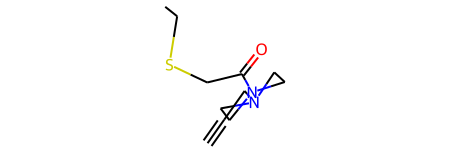

In [8]:
df_all_mols.iloc[0,0]

#####  -> removed water molecule

# Reclustering

### Combine energy and mol in one dataframe

In [9]:
df_E_Mol = pd.DataFrame()
for column in df_all_mols.columns:
    energies = df_total[column].tolist()
    mols = df_all_mols[column].tolist()
    combined = list(zip(energies, mols))
    df_E_Mol[column] = combined

In [10]:
df_E_Mol

,TOB-UNK-c2aba166-1_x1386,THO-SYG-f9b2970d-8_x1425,THO-SYG-f9b2970d-7_x1425,THO-SYG-f9b2970d-6_x1425,THO-SYG-f9b2970d-5_x1425,THO-SYG-f9b2970d-4_x1425,THO-SYG-f9b2970d-3_x1425,THO-SYG-f9b2970d-2_x1425,THO-SYG-f9b2970d-1_x1425,THO-SYG-4e0386bb-3_x1392,...,AHN-SAT-de2502ba-3_x1380,AHN-SAT-de2502ba-2_x1380,AHN-SAT-de2502ba-1_x1380,AHN-SAT-de2502ba-19_x1380,AHN-SAT-de2502ba-18_x1380,AHN-SAT-de2502ba-17_x1380,AHN-SAT-de2502ba-16_x1380,AHN-SAT-de2502ba-15_x1380,AHN-SAT-de2502ba-13_x1380,AHN-SAT-de2502ba-10_x1380
0,"(-5.42, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.55, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-7.42, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.89, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.42, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-7.55, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.51, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.28, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.12, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.68, <rdkit.Chem.rdchem.Mol object at 0x7f1...",...,"(-5.25, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.64, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.32, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-6.56, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-7.33, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-7.63, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-7.41, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-5.84, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-7.56, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-6.57, <rdkit.Chem.rdchem.Mol object at 0x7f1..."
1,"(-5.38, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-7.96, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.34, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-9.26, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.45, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-7.0, <rdkit.Chem.rdchem.Mol object at 0x7f11...","(-8.73, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-7.51, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.27, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.84, <rdkit.Chem.rdchem.Mol object at 0x7f1...",...,"(-6.09, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.51, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-7.47, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-7.49, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-7.27, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-7.92, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-6.85, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-5.59, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-6.86, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-7.07, <rdkit.Chem.rdchem.Mol object at 0x7f1..."
2,"(-5.56, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.79, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.63, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-9.3, <rdkit.Chem.rdchem.Mol object at 0x7f11...","(-7.6, <rdkit.Chem.rdchem.Mol object at 0x7f11...","(-7.06, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.67, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-7.71, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.36, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.48, <rdkit.Chem.rdchem.Mol object at 0x7f1...",...,"(-5.07, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-7.73, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.55, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-6.92, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-7.74, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-7.23, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-7.73, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-6.2, <rdkit.Chem.rdchem.Mol object at 0x7f11...","(-8.5, <rdkit.Chem.rdchem.Mol object at 0x7f11...","(-6.63, <rdkit.Chem.rdchem.Mol object at 0x7f1..."
3,"(-5.39, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-9.34, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-9.78, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.78, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-8.12, <rdkit.Chem.rdchem.Mol object at 0x7f1...","(-7.1, <rdkit.Chem.rdchem.Mol object at 0x7f11...","(-8.96, <rdkit.Chem.rdchem.Mol obje


### Main clustering code

#### new clustering code

outputs a csv for each molecule with the clusters as columns.

row 1: the mol index for each mol in teh cluster
row 2: the mean E in cluster
row 3: the stdev of E in cluster

In [11]:
from rdkit.Chem.FeatMaps import FeatMaps
import copy
import statistics
import oddt

# Threshold for RMSD clustering:
rmsd_threshold = 2

# Location of new files
cluster_path = "./AD4_scoring_clusters/"

### RMSD clustering

In [13]:
if create_new_csv_files == True:
    
    #Main loop
    for name in df_E_Mol.columns:
        print("Now running:", name)
        cluster_list = []
        cluster_mean_E_list = []
        cluster_stdev_E_list = []
        cluster_check = 0
        unsorted = df_E_Mol[name]
        dictionary = dict(df_E_Mol[name])
        dictionary_unchanged = dict(df_E_Mol[name])
        check = 0
        while len(dictionary) > 0:


            #Step 1: select top compound, calc RMSD between top and all others
            top_mol = min(dictionary.values(), key=lambda x: x[0])
            top_mol_oddt = oddt.toolkit.readstring('sdf', Chem.MolToMolBlock(top_mol[1]))
            cluster = []
            copy_dict = copy.copy(dictionary)
            for idx,mol in zip(copy_dict, list(copy_dict.values())):

                if mol == top_mol:
                    cluster.append(idx)
                    del(dictionary[idx])
                    #print("best deleted: ", idx)
                    continue
                #print("looking for fit")

                #getting the mols as oddt mol
                compare_mol_oddt = oddt.toolkit.readstring('sdf', Chem.MolToMolBlock(mol[1]))
                try:
                    rmsd_score = oddt.spatial.rmsd(top_mol_oddt, compare_mol_oddt, method='min_symmetry')
                except ValueError:
                    #print("Shapes too dissimilar, RMSD not calculated and conf not included in cluster")
                    check = 1
                    continue
                #Step 2: if < threshold -> put in one cluster    
                if rmsd_score <= rmsd_threshold:
                    cluster.append(idx)
                    del(dictionary[idx])
                    #print("deleted: ", idx)
            #Step 3: put cluster aside and return to Step 1
            energies = [dictionary_unchanged[i][0] for i in cluster]
            if len(energies) > 1:
                cluster_mean_E_list.append(statistics.mean(energies))
                cluster_stdev_E_list.append(statistics.stdev(energies))
            elif len(energies) == 1:
                cluster_mean_E_list.append(energies[0])
                cluster_stdev_E_list.append(0)
            cluster_list.append(cluster)
            print("cluster number", len(cluster_list), "mols in cluster:", len(cluster))  

        if check == 0:
            df_output = pd.DataFrame() 
            for cluster_idx in range(len(cluster_list)):
                mol_idx_list = cluster_list[cluster_idx]
                mean_E_list = cluster_mean_E_list[cluster_idx]
                stdev_E_list = cluster_stdev_E_list[cluster_idx]
                list_as_col = [mol_idx_list, mean_E_list, stdev_E_list]
                df_output["Cluster%i" %cluster_idx] = list_as_col
            df_output.index = ['Mol_indexes', 'Mean_Energy', 'StDev_Energy']
            df_output.to_csv(cluster_path+str(name)+"_RMSD_"+str(rmsd_threshold)+"_clusters.csv")
        

Now running: TOB-UNK-c2aba166-1_x1386
cluster number 1 mols in cluster: 24
cluster number 2 mols in cluster: 76
Now running: THO-SYG-f9b2970d-8_x1425
cluster number 1 mols in cluster: 23
cluster number 2 mols in cluster: 11
cluster number 3 mols in cluster: 2
cluster number 4 mols in cluster: 4
cluster number 5 mols in cluster: 6
cluster number 6 mols in cluster: 5
cluster number 7 mols in cluster: 2
cluster number 8 mols in cluster: 6
cluster number 9 mols in cluster: 3
cluster number 10 mols in cluster: 4
cluster number 11 mols in cluster: 8
cluster number 12 mols in cluster: 4
cluster number 13 mols in cluster: 4
cluster number 14 mols in cluster: 2
cluster number 15 mols in cluster: 3
cluster number 16 mols in cluster: 1
cluster number 17 mols in cluster: 5
cluster number 18 mols in cluster: 1
cluster number 19 mols in cluster: 2
cluster number 20 mols in cluster: 1
cluster number 21 mols in cluster: 1
cluster number 22 mols in cluster: 1
cluster number 23 mols in cluster: 1
Now ru

cluster number 9 mols in cluster: 2
cluster number 10 mols in cluster: 3
cluster number 11 mols in cluster: 1
cluster number 12 mols in cluster: 1
cluster number 13 mols in cluster: 9
cluster number 14 mols in cluster: 2
cluster number 15 mols in cluster: 6
cluster number 16 mols in cluster: 1
cluster number 17 mols in cluster: 1
cluster number 18 mols in cluster: 1
cluster number 19 mols in cluster: 5
cluster number 20 mols in cluster: 1
cluster number 21 mols in cluster: 1
cluster number 22 mols in cluster: 1
cluster number 23 mols in cluster: 1
cluster number 24 mols in cluster: 3
cluster number 25 mols in cluster: 1
cluster number 26 mols in cluster: 1
cluster number 27 mols in cluster: 1
cluster number 28 mols in cluster: 1
cluster number 29 mols in cluster: 1
cluster number 30 mols in cluster: 1
cluster number 31 mols in cluster: 1
Now running: STU-CHA-6cae54d3-1_x0770
cluster number 1 mols in cluster: 23
cluster number 2 mols in cluster: 13
cluster number 3 mols in cluster: 15
c

cluster number 1 mols in cluster: 58
cluster number 2 mols in cluster: 28
cluster number 3 mols in cluster: 9
cluster number 4 mols in cluster: 1
cluster number 5 mols in cluster: 4
Now running: SEL-UNI-cd366922-2_x0692
cluster number 1 mols in cluster: 39
cluster number 2 mols in cluster: 16
cluster number 3 mols in cluster: 2
cluster number 4 mols in cluster: 11
cluster number 5 mols in cluster: 1
cluster number 6 mols in cluster: 17
cluster number 7 mols in cluster: 3
cluster number 8 mols in cluster: 4
cluster number 9 mols in cluster: 1
cluster number 10 mols in cluster: 1
cluster number 11 mols in cluster: 1
cluster number 12 mols in cluster: 2
cluster number 13 mols in cluster: 1
cluster number 14 mols in cluster: 1
Now running: SEL-UNI-cd366922-1_x0692
cluster number 1 mols in cluster: 60
cluster number 2 mols in cluster: 34
cluster number 3 mols in cluster: 6
Now running: SEL-UNI-49ab05bd-4_x0749
cluster number 1 mols in cluster: 76
cluster number 2 mols in cluster: 9
cluster 

cluster number 1 mols in cluster: 41
cluster number 2 mols in cluster: 8
cluster number 3 mols in cluster: 9
cluster number 4 mols in cluster: 1
cluster number 5 mols in cluster: 4
cluster number 6 mols in cluster: 4
cluster number 7 mols in cluster: 1
cluster number 8 mols in cluster: 1
cluster number 9 mols in cluster: 4
cluster number 10 mols in cluster: 3
cluster number 11 mols in cluster: 4
cluster number 12 mols in cluster: 1
cluster number 13 mols in cluster: 2
cluster number 14 mols in cluster: 1
cluster number 15 mols in cluster: 1
cluster number 16 mols in cluster: 1
cluster number 17 mols in cluster: 1
cluster number 18 mols in cluster: 1
cluster number 19 mols in cluster: 1
cluster number 20 mols in cluster: 3
cluster number 21 mols in cluster: 1
cluster number 22 mols in cluster: 1
cluster number 23 mols in cluster: 1
cluster number 24 mols in cluster: 1
cluster number 25 mols in cluster: 1
cluster number 26 mols in cluster: 1
cluster number 27 mols in cluster: 1
cluster n

cluster number 3 mols in cluster: 2
cluster number 4 mols in cluster: 6
cluster number 5 mols in cluster: 2
cluster number 6 mols in cluster: 8
cluster number 7 mols in cluster: 6
cluster number 8 mols in cluster: 5
cluster number 9 mols in cluster: 3
cluster number 10 mols in cluster: 1
cluster number 11 mols in cluster: 1
cluster number 12 mols in cluster: 2
cluster number 13 mols in cluster: 9
cluster number 14 mols in cluster: 1
cluster number 15 mols in cluster: 5
cluster number 16 mols in cluster: 1
cluster number 17 mols in cluster: 2
cluster number 18 mols in cluster: 3
cluster number 19 mols in cluster: 2
cluster number 20 mols in cluster: 1
cluster number 21 mols in cluster: 1
cluster number 22 mols in cluster: 2
cluster number 23 mols in cluster: 1
cluster number 24 mols in cluster: 3
cluster number 25 mols in cluster: 1
cluster number 26 mols in cluster: 3
cluster number 27 mols in cluster: 2
cluster number 28 mols in cluster: 2
cluster number 29 mols in cluster: 1
cluster 

cluster number 1 mols in cluster: 15
cluster number 2 mols in cluster: 37
cluster number 3 mols in cluster: 19
cluster number 4 mols in cluster: 15
cluster number 5 mols in cluster: 13
cluster number 6 mols in cluster: 1
Now running: SAD-SAT-89668ff1-3_x0736
cluster number 1 mols in cluster: 7
cluster number 2 mols in cluster: 9
cluster number 3 mols in cluster: 15
cluster number 4 mols in cluster: 17
cluster number 5 mols in cluster: 16
cluster number 6 mols in cluster: 13
cluster number 7 mols in cluster: 4
cluster number 8 mols in cluster: 2
cluster number 9 mols in cluster: 4
cluster number 10 mols in cluster: 1
cluster number 11 mols in cluster: 5
cluster number 12 mols in cluster: 2
cluster number 13 mols in cluster: 2
cluster number 14 mols in cluster: 1
cluster number 15 mols in cluster: 2
Now running: SAD-SAT-89668ff1-2_x0736
cluster number 1 mols in cluster: 16
cluster number 2 mols in cluster: 11
cluster number 3 mols in cluster: 6
cluster number 4 mols in cluster: 12
cluste

cluster number 10 mols in cluster: 3
cluster number 11 mols in cluster: 2
cluster number 12 mols in cluster: 4
cluster number 13 mols in cluster: 1
cluster number 14 mols in cluster: 1
cluster number 15 mols in cluster: 1
cluster number 16 mols in cluster: 1
cluster number 17 mols in cluster: 1
cluster number 18 mols in cluster: 1
Now running: SAD-SAT-29425be4-5_x0770
cluster number 1 mols in cluster: 2
cluster number 2 mols in cluster: 3
cluster number 3 mols in cluster: 2
cluster number 4 mols in cluster: 1
cluster number 5 mols in cluster: 1
cluster number 6 mols in cluster: 10
cluster number 7 mols in cluster: 2
cluster number 8 mols in cluster: 3
cluster number 9 mols in cluster: 1
cluster number 10 mols in cluster: 5
cluster number 11 mols in cluster: 1
cluster number 12 mols in cluster: 2
cluster number 13 mols in cluster: 3
cluster number 14 mols in cluster: 1
cluster number 15 mols in cluster: 1
cluster number 16 mols in cluster: 3
cluster number 17 mols in cluster: 1
cluster 

cluster number 1 mols in cluster: 31
cluster number 2 mols in cluster: 3
cluster number 3 mols in cluster: 9
cluster number 4 mols in cluster: 6
cluster number 5 mols in cluster: 2
cluster number 6 mols in cluster: 10
cluster number 7 mols in cluster: 5
cluster number 8 mols in cluster: 2
cluster number 9 mols in cluster: 10
cluster number 10 mols in cluster: 1
cluster number 11 mols in cluster: 2
cluster number 12 mols in cluster: 1
cluster number 13 mols in cluster: 1
cluster number 14 mols in cluster: 3
cluster number 15 mols in cluster: 1
cluster number 16 mols in cluster: 2
cluster number 17 mols in cluster: 1
cluster number 18 mols in cluster: 1
cluster number 19 mols in cluster: 1
cluster number 20 mols in cluster: 2
cluster number 21 mols in cluster: 2
cluster number 22 mols in cluster: 1
cluster number 23 mols in cluster: 1
cluster number 24 mols in cluster: 1
cluster number 25 mols in cluster: 1
Now running: SAD-SAT-29425be4-23_x0770
cluster number 1 mols in cluster: 21
clust

cluster number 10 mols in cluster: 5
cluster number 11 mols in cluster: 2
cluster number 12 mols in cluster: 2
cluster number 13 mols in cluster: 8
cluster number 14 mols in cluster: 1
cluster number 15 mols in cluster: 1
cluster number 16 mols in cluster: 2
cluster number 17 mols in cluster: 4
cluster number 18 mols in cluster: 2
cluster number 19 mols in cluster: 1
cluster number 20 mols in cluster: 1
cluster number 21 mols in cluster: 1
cluster number 22 mols in cluster: 1
cluster number 23 mols in cluster: 1
cluster number 24 mols in cluster: 1
cluster number 25 mols in cluster: 1
cluster number 26 mols in cluster: 1
Now running: SAD-SAT-29425be4-16_x0770
cluster number 1 mols in cluster: 19
cluster number 2 mols in cluster: 42
cluster number 3 mols in cluster: 4
cluster number 4 mols in cluster: 23
cluster number 5 mols in cluster: 6
cluster number 6 mols in cluster: 2
cluster number 7 mols in cluster: 2
cluster number 8 mols in cluster: 1
cluster number 9 mols in cluster: 1
Now r

cluster number 1 mols in cluster: 44
cluster number 2 mols in cluster: 24
cluster number 3 mols in cluster: 3
cluster number 4 mols in cluster: 17
cluster number 5 mols in cluster: 10
cluster number 6 mols in cluster: 1
cluster number 7 mols in cluster: 1
Now running: PAU-UNI-8cdd41c7-1_x0770
cluster number 1 mols in cluster: 24
cluster number 2 mols in cluster: 34
cluster number 3 mols in cluster: 2
cluster number 4 mols in cluster: 21
cluster number 5 mols in cluster: 13
cluster number 6 mols in cluster: 4
cluster number 7 mols in cluster: 1
cluster number 8 mols in cluster: 1
Now running: PAU-UNI-2d648ace-1_x0770
cluster number 1 mols in cluster: 14
cluster number 2 mols in cluster: 21
cluster number 3 mols in cluster: 12
cluster number 4 mols in cluster: 1
cluster number 5 mols in cluster: 6
cluster number 6 mols in cluster: 6
cluster number 7 mols in cluster: 4
cluster number 8 mols in cluster: 2
cluster number 9 mols in cluster: 3
cluster number 10 mols in cluster: 2
cluster numb

cluster number 15 mols in cluster: 2
cluster number 16 mols in cluster: 1
cluster number 17 mols in cluster: 1
cluster number 18 mols in cluster: 2
Now running: NIM-UNI-43fe0159-9_x0759
cluster number 1 mols in cluster: 92
cluster number 2 mols in cluster: 3
cluster number 3 mols in cluster: 3
cluster number 4 mols in cluster: 1
cluster number 5 mols in cluster: 1
Now running: NIM-UNI-43fe0159-8_x0759
cluster number 1 mols in cluster: 85
cluster number 2 mols in cluster: 6
cluster number 3 mols in cluster: 1
cluster number 4 mols in cluster: 8
Now running: NIM-UNI-43fe0159-7_x0759
cluster number 1 mols in cluster: 75
cluster number 2 mols in cluster: 11
cluster number 3 mols in cluster: 7
cluster number 4 mols in cluster: 6
cluster number 5 mols in cluster: 1
Now running: NIM-UNI-43fe0159-6_x0759
cluster number 1 mols in cluster: 35
cluster number 2 mols in cluster: 55
cluster number 3 mols in cluster: 8
cluster number 4 mols in cluster: 2
Now running: NIM-UNI-43fe0159-5_x0759
cluster 

cluster number 2 mols in cluster: 1
cluster number 3 mols in cluster: 44
cluster number 4 mols in cluster: 23
cluster number 5 mols in cluster: 9
cluster number 6 mols in cluster: 9
cluster number 7 mols in cluster: 2
cluster number 8 mols in cluster: 2
Now running: NIM-UNI-310206f0-54_x0770
cluster number 1 mols in cluster: 55
cluster number 2 mols in cluster: 3
cluster number 3 mols in cluster: 1
cluster number 4 mols in cluster: 11
cluster number 5 mols in cluster: 2
cluster number 6 mols in cluster: 4
cluster number 7 mols in cluster: 2
cluster number 8 mols in cluster: 2
cluster number 9 mols in cluster: 3
cluster number 10 mols in cluster: 3
cluster number 11 mols in cluster: 4
cluster number 12 mols in cluster: 4
cluster number 13 mols in cluster: 1
cluster number 14 mols in cluster: 1
cluster number 15 mols in cluster: 1
cluster number 16 mols in cluster: 1
cluster number 17 mols in cluster: 1
cluster number 18 mols in cluster: 1
Now running: NIM-UNI-310206f0-51_x0770
cluster n

cluster number 7 mols in cluster: 4
cluster number 8 mols in cluster: 1
cluster number 9 mols in cluster: 1
cluster number 10 mols in cluster: 5
cluster number 11 mols in cluster: 9
cluster number 12 mols in cluster: 4
cluster number 13 mols in cluster: 3
cluster number 14 mols in cluster: 2
cluster number 15 mols in cluster: 1
cluster number 16 mols in cluster: 1
cluster number 17 mols in cluster: 7
cluster number 18 mols in cluster: 2
cluster number 19 mols in cluster: 1
cluster number 20 mols in cluster: 1
cluster number 21 mols in cluster: 1
Now running: NIM-UNI-310206f0-32_x0770
cluster number 1 mols in cluster: 28
cluster number 2 mols in cluster: 20
cluster number 3 mols in cluster: 5
cluster number 4 mols in cluster: 11
cluster number 5 mols in cluster: 1
cluster number 6 mols in cluster: 17
cluster number 7 mols in cluster: 5
cluster number 8 mols in cluster: 3
cluster number 9 mols in cluster: 3
cluster number 10 mols in cluster: 3
cluster number 11 mols in cluster: 3
cluster

cluster number 11 mols in cluster: 1
cluster number 12 mols in cluster: 1
cluster number 13 mols in cluster: 1
cluster number 14 mols in cluster: 1
Now running: NIM-UNI-310206f0-16_x0770
cluster number 1 mols in cluster: 38
cluster number 2 mols in cluster: 2
cluster number 3 mols in cluster: 7
cluster number 4 mols in cluster: 18
cluster number 5 mols in cluster: 2
cluster number 6 mols in cluster: 6
cluster number 7 mols in cluster: 14
cluster number 8 mols in cluster: 8
cluster number 9 mols in cluster: 1
cluster number 10 mols in cluster: 2
cluster number 11 mols in cluster: 1
cluster number 12 mols in cluster: 1
Now running: NIM-UNI-310206f0-15_x0770
cluster number 1 mols in cluster: 44
cluster number 2 mols in cluster: 7
cluster number 3 mols in cluster: 13
cluster number 4 mols in cluster: 3
cluster number 5 mols in cluster: 4
cluster number 6 mols in cluster: 10
cluster number 7 mols in cluster: 7
cluster number 8 mols in cluster: 3
cluster number 9 mols in cluster: 2
cluster n

cluster number 6 mols in cluster: 3
cluster number 7 mols in cluster: 4
cluster number 8 mols in cluster: 5
cluster number 9 mols in cluster: 1
cluster number 10 mols in cluster: 2
cluster number 11 mols in cluster: 2
cluster number 12 mols in cluster: 4
cluster number 13 mols in cluster: 1
Now running: MAK-UNK-ec98eaf6-6_x0770
cluster number 1 mols in cluster: 48
cluster number 2 mols in cluster: 23
cluster number 3 mols in cluster: 9
cluster number 4 mols in cluster: 9
cluster number 5 mols in cluster: 2
cluster number 6 mols in cluster: 1
cluster number 7 mols in cluster: 5
cluster number 8 mols in cluster: 1
cluster number 9 mols in cluster: 2
Now running: MAK-UNK-ec98eaf6-5_x0770
cluster number 1 mols in cluster: 8
cluster number 2 mols in cluster: 5
cluster number 3 mols in cluster: 6
cluster number 4 mols in cluster: 14
cluster number 5 mols in cluster: 31
cluster number 6 mols in cluster: 4
cluster number 7 mols in cluster: 10
cluster number 8 mols in cluster: 1
cluster number 

cluster number 1 mols in cluster: 68
cluster number 2 mols in cluster: 16
cluster number 3 mols in cluster: 5
cluster number 4 mols in cluster: 5
cluster number 5 mols in cluster: 1
cluster number 6 mols in cluster: 4
cluster number 7 mols in cluster: 1
Now running: MAK-UNK-ec98eaf6-42_x0770
cluster number 1 mols in cluster: 73
cluster number 2 mols in cluster: 23
cluster number 3 mols in cluster: 4
Now running: MAK-UNK-ec98eaf6-40_x0770
cluster number 1 mols in cluster: 83
cluster number 2 mols in cluster: 8
cluster number 3 mols in cluster: 6
cluster number 4 mols in cluster: 2
cluster number 5 mols in cluster: 1
Now running: MAK-UNK-ec98eaf6-3_x0770
cluster number 1 mols in cluster: 70
cluster number 2 mols in cluster: 8
cluster number 3 mols in cluster: 6
cluster number 4 mols in cluster: 1
cluster number 5 mols in cluster: 1
cluster number 6 mols in cluster: 13
cluster number 7 mols in cluster: 1
Now running: MAK-UNK-ec98eaf6-39_x0770
cluster number 1 mols in cluster: 41
cluster n

cluster number 3 mols in cluster: 4
cluster number 4 mols in cluster: 1
cluster number 5 mols in cluster: 8
cluster number 6 mols in cluster: 5
cluster number 7 mols in cluster: 3
cluster number 8 mols in cluster: 4
cluster number 9 mols in cluster: 2
cluster number 10 mols in cluster: 1
Now running: MAK-UNK-ec98eaf6-20_x0770
cluster number 1 mols in cluster: 2
cluster number 2 mols in cluster: 8
cluster number 3 mols in cluster: 19
cluster number 4 mols in cluster: 63
cluster number 5 mols in cluster: 3
cluster number 6 mols in cluster: 1
cluster number 7 mols in cluster: 2
cluster number 8 mols in cluster: 1
cluster number 9 mols in cluster: 1
Now running: MAK-UNK-ec98eaf6-1_x0770
cluster number 1 mols in cluster: 45
cluster number 2 mols in cluster: 2
cluster number 3 mols in cluster: 3
cluster number 4 mols in cluster: 12
cluster number 5 mols in cluster: 5
cluster number 6 mols in cluster: 9
cluster number 7 mols in cluster: 6
cluster number 8 mols in cluster: 6
cluster number 9 m

cluster number 11 mols in cluster: 1
cluster number 12 mols in cluster: 1
Now running: MAK-UNK-e4a48a85-25_x0692
cluster number 1 mols in cluster: 8
cluster number 2 mols in cluster: 37
cluster number 3 mols in cluster: 3
cluster number 4 mols in cluster: 4
cluster number 5 mols in cluster: 6
cluster number 6 mols in cluster: 2
cluster number 7 mols in cluster: 3
cluster number 8 mols in cluster: 4
cluster number 9 mols in cluster: 6
cluster number 10 mols in cluster: 6
cluster number 11 mols in cluster: 3
cluster number 12 mols in cluster: 1
cluster number 13 mols in cluster: 1
cluster number 14 mols in cluster: 3
cluster number 15 mols in cluster: 5
cluster number 16 mols in cluster: 1
cluster number 17 mols in cluster: 1
cluster number 18 mols in cluster: 1
cluster number 19 mols in cluster: 2
cluster number 20 mols in cluster: 1
cluster number 21 mols in cluster: 1
cluster number 22 mols in cluster: 1
Now running: MAK-UNK-e4a48a85-23_x0692
cluster number 1 mols in cluster: 47
clust

cluster number 1 mols in cluster: 11
cluster number 2 mols in cluster: 3
cluster number 3 mols in cluster: 7
cluster number 4 mols in cluster: 11
cluster number 5 mols in cluster: 9
cluster number 6 mols in cluster: 4
cluster number 7 mols in cluster: 7
cluster number 8 mols in cluster: 5
cluster number 9 mols in cluster: 1
cluster number 10 mols in cluster: 2
cluster number 11 mols in cluster: 4
cluster number 12 mols in cluster: 3
cluster number 13 mols in cluster: 6
cluster number 14 mols in cluster: 4
cluster number 15 mols in cluster: 7
cluster number 16 mols in cluster: 9
cluster number 17 mols in cluster: 1
cluster number 18 mols in cluster: 4
cluster number 19 mols in cluster: 1
cluster number 20 mols in cluster: 1
Now running: MAK-UNK-bae89c02-3_x0770
cluster number 1 mols in cluster: 30
cluster number 2 mols in cluster: 3
cluster number 3 mols in cluster: 18
cluster number 4 mols in cluster: 14
cluster number 5 mols in cluster: 13
cluster number 6 mols in cluster: 4
cluster n

cluster number 13 mols in cluster: 2
cluster number 14 mols in cluster: 1
cluster number 15 mols in cluster: 3
cluster number 16 mols in cluster: 1
cluster number 17 mols in cluster: 1
cluster number 18 mols in cluster: 1
cluster number 19 mols in cluster: 2
cluster number 20 mols in cluster: 4
cluster number 21 mols in cluster: 1
cluster number 22 mols in cluster: 1
cluster number 23 mols in cluster: 1
cluster number 24 mols in cluster: 1
cluster number 25 mols in cluster: 1
cluster number 26 mols in cluster: 1
cluster number 27 mols in cluster: 1
cluster number 28 mols in cluster: 1
Now running: MAK-UNK-af83ef51-25_x0692
cluster number 1 mols in cluster: 11
cluster number 2 mols in cluster: 23
cluster number 3 mols in cluster: 5
cluster number 4 mols in cluster: 5
cluster number 5 mols in cluster: 17
cluster number 6 mols in cluster: 7
cluster number 7 mols in cluster: 1
cluster number 8 mols in cluster: 3
cluster number 9 mols in cluster: 6
cluster number 10 mols in cluster: 3
clust

cluster number 1 mols in cluster: 16
cluster number 2 mols in cluster: 6
cluster number 3 mols in cluster: 14
cluster number 4 mols in cluster: 6
cluster number 5 mols in cluster: 4
cluster number 6 mols in cluster: 16
cluster number 7 mols in cluster: 9
cluster number 8 mols in cluster: 1
cluster number 9 mols in cluster: 1
cluster number 10 mols in cluster: 3
cluster number 11 mols in cluster: 2
cluster number 12 mols in cluster: 1
cluster number 13 mols in cluster: 1
cluster number 14 mols in cluster: 1
cluster number 15 mols in cluster: 3
cluster number 16 mols in cluster: 2
cluster number 17 mols in cluster: 2
cluster number 18 mols in cluster: 3
cluster number 19 mols in cluster: 1
cluster number 20 mols in cluster: 1
cluster number 21 mols in cluster: 1
cluster number 22 mols in cluster: 1
cluster number 23 mols in cluster: 1
cluster number 24 mols in cluster: 1
cluster number 25 mols in cluster: 1
cluster number 26 mols in cluster: 1
cluster number 27 mols in cluster: 1
Now run

cluster number 1 mols in cluster: 38
cluster number 2 mols in cluster: 15
cluster number 3 mols in cluster: 1
cluster number 4 mols in cluster: 8
cluster number 5 mols in cluster: 3
cluster number 6 mols in cluster: 1
cluster number 7 mols in cluster: 4
cluster number 8 mols in cluster: 2
cluster number 9 mols in cluster: 4
cluster number 10 mols in cluster: 2
cluster number 11 mols in cluster: 6
cluster number 12 mols in cluster: 2
cluster number 13 mols in cluster: 2
cluster number 14 mols in cluster: 2
cluster number 15 mols in cluster: 1
cluster number 16 mols in cluster: 2
cluster number 17 mols in cluster: 1
cluster number 18 mols in cluster: 1
cluster number 19 mols in cluster: 1
cluster number 20 mols in cluster: 1
cluster number 21 mols in cluster: 1
cluster number 22 mols in cluster: 1
cluster number 23 mols in cluster: 1
Now running: MAK-UNK-90d0606b-10_x0770
cluster number 1 mols in cluster: 62
cluster number 2 mols in cluster: 32
cluster number 3 mols in cluster: 4
cluster

cluster number 5 mols in cluster: 3
cluster number 6 mols in cluster: 3
cluster number 7 mols in cluster: 2
cluster number 8 mols in cluster: 2
cluster number 9 mols in cluster: 2
cluster number 10 mols in cluster: 4
cluster number 11 mols in cluster: 1
cluster number 12 mols in cluster: 5
cluster number 13 mols in cluster: 1
cluster number 14 mols in cluster: 2
cluster number 15 mols in cluster: 1
cluster number 16 mols in cluster: 2
cluster number 17 mols in cluster: 2
cluster number 18 mols in cluster: 1
cluster number 19 mols in cluster: 1
cluster number 20 mols in cluster: 1
cluster number 21 mols in cluster: 1
cluster number 22 mols in cluster: 1
Now running: MAK-UNK-849bee6c-22_x0692
cluster number 1 mols in cluster: 6
cluster number 2 mols in cluster: 1
cluster number 3 mols in cluster: 3
cluster number 4 mols in cluster: 10
cluster number 5 mols in cluster: 2
cluster number 6 mols in cluster: 1
cluster number 7 mols in cluster: 5
cluster number 8 mols in cluster: 2
cluster num

cluster number 9 mols in cluster: 1
cluster number 10 mols in cluster: 2
cluster number 11 mols in cluster: 1
cluster number 12 mols in cluster: 1
Now running: MAK-UNK-7d5cf6bf-1_x0692
cluster number 1 mols in cluster: 12
cluster number 2 mols in cluster: 9
cluster number 3 mols in cluster: 1
cluster number 4 mols in cluster: 17
cluster number 5 mols in cluster: 1
cluster number 6 mols in cluster: 3
cluster number 7 mols in cluster: 2
cluster number 8 mols in cluster: 10
cluster number 9 mols in cluster: 2
cluster number 10 mols in cluster: 4
cluster number 11 mols in cluster: 1
cluster number 12 mols in cluster: 3
cluster number 13 mols in cluster: 1
cluster number 14 mols in cluster: 4
cluster number 15 mols in cluster: 5
cluster number 16 mols in cluster: 2
cluster number 17 mols in cluster: 1
cluster number 18 mols in cluster: 3
cluster number 19 mols in cluster: 2
cluster number 20 mols in cluster: 2
cluster number 21 mols in cluster: 1
cluster number 22 mols in cluster: 1
cluster

cluster number 1 mols in cluster: 33
cluster number 2 mols in cluster: 20
cluster number 3 mols in cluster: 11
cluster number 4 mols in cluster: 21
cluster number 5 mols in cluster: 4
cluster number 6 mols in cluster: 1
cluster number 7 mols in cluster: 4
cluster number 8 mols in cluster: 3
cluster number 9 mols in cluster: 1
cluster number 10 mols in cluster: 1
cluster number 11 mols in cluster: 1
Now running: MAK-UNK-5d2caa6f-23_x0770
cluster number 1 mols in cluster: 11
cluster number 2 mols in cluster: 14
cluster number 3 mols in cluster: 9
cluster number 4 mols in cluster: 1
cluster number 5 mols in cluster: 13
cluster number 6 mols in cluster: 8
cluster number 7 mols in cluster: 2
cluster number 8 mols in cluster: 5
cluster number 9 mols in cluster: 4
cluster number 10 mols in cluster: 2
cluster number 11 mols in cluster: 2
cluster number 12 mols in cluster: 1
cluster number 13 mols in cluster: 1
cluster number 14 mols in cluster: 2
cluster number 15 mols in cluster: 1
cluster nu

cluster number 13 mols in cluster: 1
cluster number 14 mols in cluster: 1
cluster number 15 mols in cluster: 1
cluster number 16 mols in cluster: 1
cluster number 17 mols in cluster: 1
cluster number 18 mols in cluster: 1
cluster number 19 mols in cluster: 2
cluster number 20 mols in cluster: 1
cluster number 21 mols in cluster: 1
cluster number 22 mols in cluster: 1
cluster number 23 mols in cluster: 1
Now running: MAK-UNK-176ca439-2_x0692
cluster number 1 mols in cluster: 11
cluster number 2 mols in cluster: 9
cluster number 3 mols in cluster: 6
cluster number 4 mols in cluster: 11
cluster number 5 mols in cluster: 3
cluster number 6 mols in cluster: 5
cluster number 7 mols in cluster: 1
cluster number 8 mols in cluster: 2
cluster number 9 mols in cluster: 3
cluster number 10 mols in cluster: 1
cluster number 11 mols in cluster: 4
cluster number 12 mols in cluster: 1
cluster number 13 mols in cluster: 2
cluster number 14 mols in cluster: 2
cluster number 15 mols in cluster: 1
cluster

cluster number 5 mols in cluster: 3
cluster number 6 mols in cluster: 1
cluster number 7 mols in cluster: 1
Now running: MAK-UNK-10799360-32_x0770
cluster number 1 mols in cluster: 14
cluster number 2 mols in cluster: 10
cluster number 3 mols in cluster: 28
cluster number 4 mols in cluster: 7
cluster number 5 mols in cluster: 5
cluster number 6 mols in cluster: 5
cluster number 7 mols in cluster: 1
cluster number 8 mols in cluster: 5
cluster number 9 mols in cluster: 2
cluster number 10 mols in cluster: 3
cluster number 11 mols in cluster: 2
cluster number 12 mols in cluster: 3
cluster number 13 mols in cluster: 3
cluster number 14 mols in cluster: 1
cluster number 15 mols in cluster: 2
cluster number 16 mols in cluster: 2
cluster number 17 mols in cluster: 2
cluster number 18 mols in cluster: 1
cluster number 19 mols in cluster: 1
cluster number 20 mols in cluster: 1
cluster number 21 mols in cluster: 1
cluster number 22 mols in cluster: 1
Now running: MAK-UNK-10799360-30_x0770
cluste

cluster number 1 mols in cluster: 9
cluster number 2 mols in cluster: 46
cluster number 3 mols in cluster: 34
cluster number 4 mols in cluster: 6
cluster number 5 mols in cluster: 2
cluster number 6 mols in cluster: 2
cluster number 7 mols in cluster: 1
Now running: MAK-UNK-10799360-17_x0770
cluster number 1 mols in cluster: 59
cluster number 2 mols in cluster: 14
cluster number 3 mols in cluster: 1
cluster number 4 mols in cluster: 2
cluster number 5 mols in cluster: 10
cluster number 6 mols in cluster: 2
cluster number 7 mols in cluster: 7
cluster number 8 mols in cluster: 1
cluster number 9 mols in cluster: 1
cluster number 10 mols in cluster: 1
cluster number 11 mols in cluster: 1
cluster number 12 mols in cluster: 1
Now running: MAK-UNK-10799360-16_x0770
cluster number 1 mols in cluster: 51
cluster number 2 mols in cluster: 32
cluster number 3 mols in cluster: 2
cluster number 4 mols in cluster: 4
cluster number 5 mols in cluster: 2
cluster number 6 mols in cluster: 2
cluster numb

cluster number 1 mols in cluster: 45
cluster number 2 mols in cluster: 36
cluster number 3 mols in cluster: 5
cluster number 4 mols in cluster: 3
cluster number 5 mols in cluster: 1
cluster number 6 mols in cluster: 1
cluster number 7 mols in cluster: 1
cluster number 8 mols in cluster: 3
cluster number 9 mols in cluster: 1
cluster number 10 mols in cluster: 1
cluster number 11 mols in cluster: 1
cluster number 12 mols in cluster: 1
cluster number 13 mols in cluster: 1
Now running: JOK-SYG-8934678c-1_x0759
cluster number 1 mols in cluster: 48
cluster number 2 mols in cluster: 52
Now running: JOK-SYG-6ec557d2-1_x0770
cluster number 1 mols in cluster: 3
cluster number 2 mols in cluster: 9
cluster number 3 mols in cluster: 6
cluster number 4 mols in cluster: 11
cluster number 5 mols in cluster: 9
cluster number 6 mols in cluster: 2
cluster number 7 mols in cluster: 10
cluster number 8 mols in cluster: 4
cluster number 9 mols in cluster: 25
cluster number 10 mols in cluster: 8
cluster numb

cluster number 2 mols in cluster: 49
cluster number 3 mols in cluster: 21
cluster number 4 mols in cluster: 3
cluster number 5 mols in cluster: 1
cluster number 6 mols in cluster: 1
cluster number 7 mols in cluster: 1
Now running: IAN-BAS-44680fdf-1_x1493
cluster number 1 mols in cluster: 2
cluster number 2 mols in cluster: 21
cluster number 3 mols in cluster: 22
cluster number 4 mols in cluster: 6
cluster number 5 mols in cluster: 32
cluster number 6 mols in cluster: 1
cluster number 7 mols in cluster: 1
cluster number 8 mols in cluster: 5
cluster number 9 mols in cluster: 1
cluster number 10 mols in cluster: 2
cluster number 11 mols in cluster: 1
cluster number 12 mols in cluster: 3
cluster number 13 mols in cluster: 1
cluster number 14 mols in cluster: 1
cluster number 15 mols in cluster: 1
Now running: GIA-UNK-20b63697-9_x1380
cluster number 1 mols in cluster: 27
cluster number 2 mols in cluster: 17
cluster number 3 mols in cluster: 8
cluster number 4 mols in cluster: 20
cluster nu

cluster number 1 mols in cluster: 83
cluster number 2 mols in cluster: 17
Now running: DAV-CRI-3fe943ba-1_x1392
cluster number 1 mols in cluster: 19
cluster number 2 mols in cluster: 78
cluster number 3 mols in cluster: 3
Now running: DAV-CRI-3edb475e-6_x1382
cluster number 1 mols in cluster: 45
cluster number 2 mols in cluster: 24
cluster number 3 mols in cluster: 14
cluster number 4 mols in cluster: 9
cluster number 5 mols in cluster: 3
cluster number 6 mols in cluster: 1
cluster number 7 mols in cluster: 1
cluster number 8 mols in cluster: 1
cluster number 9 mols in cluster: 1
cluster number 10 mols in cluster: 1
Now running: DAV-CRI-3edb475e-5_x1382
cluster number 1 mols in cluster: 26
cluster number 2 mols in cluster: 21
cluster number 3 mols in cluster: 6
cluster number 4 mols in cluster: 6
cluster number 5 mols in cluster: 7
cluster number 6 mols in cluster: 4
cluster number 7 mols in cluster: 11
cluster number 8 mols in cluster: 3
cluster number 9 mols in cluster: 4
cluster num

cluster number 1 mols in cluster: 2
cluster number 2 mols in cluster: 1
cluster number 3 mols in cluster: 24
cluster number 4 mols in cluster: 6
cluster number 5 mols in cluster: 1
cluster number 6 mols in cluster: 7
cluster number 7 mols in cluster: 6
cluster number 8 mols in cluster: 5
cluster number 9 mols in cluster: 3
cluster number 10 mols in cluster: 7
cluster number 11 mols in cluster: 4
cluster number 12 mols in cluster: 1
cluster number 13 mols in cluster: 4
cluster number 14 mols in cluster: 4
cluster number 15 mols in cluster: 1
cluster number 16 mols in cluster: 2
cluster number 17 mols in cluster: 3
cluster number 18 mols in cluster: 3
cluster number 19 mols in cluster: 2
cluster number 20 mols in cluster: 1
cluster number 21 mols in cluster: 1
cluster number 22 mols in cluster: 1
cluster number 23 mols in cluster: 1
cluster number 24 mols in cluster: 1
cluster number 25 mols in cluster: 1
cluster number 26 mols in cluster: 1
cluster number 27 mols in cluster: 1
cluster n

cluster number 6 mols in cluster: 4
cluster number 7 mols in cluster: 6
cluster number 8 mols in cluster: 1
cluster number 9 mols in cluster: 2
cluster number 10 mols in cluster: 1
cluster number 11 mols in cluster: 1
cluster number 12 mols in cluster: 1
cluster number 13 mols in cluster: 1
cluster number 14 mols in cluster: 1
cluster number 15 mols in cluster: 1
cluster number 16 mols in cluster: 7
cluster number 17 mols in cluster: 1
cluster number 18 mols in cluster: 1
cluster number 19 mols in cluster: 1
cluster number 20 mols in cluster: 1
cluster number 21 mols in cluster: 1
cluster number 22 mols in cluster: 2
cluster number 23 mols in cluster: 1
cluster number 24 mols in cluster: 3
cluster number 25 mols in cluster: 1
cluster number 26 mols in cluster: 1
Now running: DAR-DIA-fb20be43-16_x0830
cluster number 1 mols in cluster: 16
cluster number 2 mols in cluster: 1
cluster number 3 mols in cluster: 8
cluster number 4 mols in cluster: 11
cluster number 5 mols in cluster: 7
cluste

cluster number 11 mols in cluster: 2
cluster number 12 mols in cluster: 14
cluster number 13 mols in cluster: 1
cluster number 14 mols in cluster: 1
cluster number 15 mols in cluster: 1
cluster number 16 mols in cluster: 1
cluster number 17 mols in cluster: 2
cluster number 18 mols in cluster: 1
Now running: BOG-INS-6c21c533-1_x0692
cluster number 1 mols in cluster: 34
cluster number 2 mols in cluster: 1
cluster number 3 mols in cluster: 1
cluster number 4 mols in cluster: 3
cluster number 5 mols in cluster: 9
cluster number 6 mols in cluster: 4
cluster number 7 mols in cluster: 10
cluster number 8 mols in cluster: 5
cluster number 9 mols in cluster: 6
cluster number 10 mols in cluster: 1
cluster number 11 mols in cluster: 7
cluster number 12 mols in cluster: 4
cluster number 13 mols in cluster: 1
cluster number 14 mols in cluster: 3
cluster number 15 mols in cluster: 1
cluster number 16 mols in cluster: 2
cluster number 17 mols in cluster: 3
cluster number 18 mols in cluster: 4
cluste

cluster number 4 mols in cluster: 58
cluster number 5 mols in cluster: 1
cluster number 6 mols in cluster: 1
cluster number 7 mols in cluster: 1
cluster number 8 mols in cluster: 2
Now running: AHN-SAT-de2502ba-9_x1380
cluster number 1 mols in cluster: 9
cluster number 2 mols in cluster: 12
cluster number 3 mols in cluster: 5
cluster number 4 mols in cluster: 6
cluster number 5 mols in cluster: 16
cluster number 6 mols in cluster: 7
cluster number 7 mols in cluster: 17
cluster number 8 mols in cluster: 1
cluster number 9 mols in cluster: 1
cluster number 10 mols in cluster: 4
cluster number 11 mols in cluster: 6
cluster number 12 mols in cluster: 1
cluster number 13 mols in cluster: 3
cluster number 14 mols in cluster: 1
cluster number 15 mols in cluster: 1
cluster number 16 mols in cluster: 2
cluster number 17 mols in cluster: 4
cluster number 18 mols in cluster: 1
cluster number 19 mols in cluster: 2
cluster number 20 mols in cluster: 1
Now running: AHN-SAT-de2502ba-8_x1380
cluster n

cluster number 7 mols in cluster: 10
cluster number 8 mols in cluster: 2
cluster number 9 mols in cluster: 3
cluster number 10 mols in cluster: 1
cluster number 11 mols in cluster: 1
cluster number 12 mols in cluster: 3
cluster number 13 mols in cluster: 2
cluster number 14 mols in cluster: 4
cluster number 15 mols in cluster: 7
cluster number 16 mols in cluster: 1
cluster number 17 mols in cluster: 1
cluster number 18 mols in cluster: 1
cluster number 19 mols in cluster: 1
cluster number 20 mols in cluster: 1
cluster number 21 mols in cluster: 1
Now running: AHN-SAT-de2502ba-13_x1380
cluster number 1 mols in cluster: 32
cluster number 2 mols in cluster: 29
cluster number 3 mols in cluster: 5
cluster number 4 mols in cluster: 2
cluster number 5 mols in cluster: 9
cluster number 6 mols in cluster: 13
cluster number 7 mols in cluster: 3
cluster number 8 mols in cluster: 3
cluster number 9 mols in cluster: 1
cluster number 10 mols in cluster: 1
cluster number 11 mols in cluster: 2
Now run